<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tuning-Learning-Rates" data-toc-modified-id="Tuning-Learning-Rates-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tuning Learning Rates</a></span><ul class="toc-item"><li><span><a href="#Learning-Rate-Finder" data-toc-modified-id="Learning-Rate-Finder-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Learning Rate Finder</a></span></li><li><span><a href="#Cyclical-Learning-Rate-(CLR)" data-toc-modified-id="Cyclical-Learning-Rate-(CLR)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Cyclical Learning Rate (CLR)</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
# 3. magic for inline plot
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%load_ext watermark
%load_ext autoreload 
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,keras,matplotlib

Using TensorFlow backend.


Ethen 2018-04-13 22:31:50 

CPython 3.6.4
IPython 6.2.1

numpy 1.14.2
pandas 0.22.0
keras 2.1.5
matplotlib 2.2.2


# Tuning Learning Rates

Many machine learning algorithms especially in the realms of deep learning uses gradient descent based algorithms to train the model, and this type of numerical optimization requires the end-user to set the learning rate. This parameter tells the optimizer how aggressive should it be in adjusting the weights in the direction of the gradient.

If the learning rate is too low, then training will potentially be more reliable, but the optimization process will take loads of time because steps towards the minimum of the loss function are tiny. On the other hand, if the learning rate is high, then training may not converge or even diverge, as weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.

<img src="img/learning_rate.png" width="80%" height="80%">

In this documentation we'll be looking at some ways to determine this critical hyperparameter.

In [3]:
n_classes = 10
n_features = 784  # mnist is a 28 * 28 image

# load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, n_features)
X_test = X_test.reshape(10000, n_features)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# images takes values between 0 - 255, we can normalize it
# by dividing every number by 255
X_train /= 255
X_test /= 255

# convert label to one-hot encoded format so it's keras compatible
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test , n_classes)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [4]:
# define a small sequential model
model = Sequential()
model.add(Dense(512, input_dim = n_features))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])

## Learning Rate Finder

One trick to select a reasonable range for our network is to train a network starting from a low learning rate and increase the learning rate exponentially for every batch. We record the learning rate and loss for every batch and when the loss gets a lot higher than the previously observed best value we stop this procedure.

In [5]:
from keras_utils import LRFind


n_epochs = 40
batch_size = 512
validation_split = 0.2
iterations = (X_train.shape[0] * (1 - validation_split)) / batch_size

# use the min_lr and max_lr to set the lower and upper bound
# jump to indicate if the current loss is x times larger than
# the best loss, we should stop the process
lr_find = LRFind(iterations = iterations,
                 min_lr = 0.0001, max_lr = 10, jump = 6)

model.fit(X_train, Y_train, batch_size = batch_size, 
          epochs = n_epochs, verbose = 1,
          validation_split = validation_split,
          callbacks = [lr_find])

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
20480/48000 [===========>..................] - ETA: 1s - loss: 1.5672 - acc: 0.5517

Site note: For validation split, the validation dataset will be the last x percentage of the data as keras does not perform a shuffle internally for this split, thus we should ensure there isn't any inherent ordering to our dataset. On the other hand, the training data is shuffle during each epoch since the `shuffle` argument is set to True by default for the fit method.

After this step, we look at the plot with the learning rate versus loss. A typical plot usually starts off with the loss gradually improving with low learning rates, then the training accelerates until the learning rate becomes too large and the training process diverge.

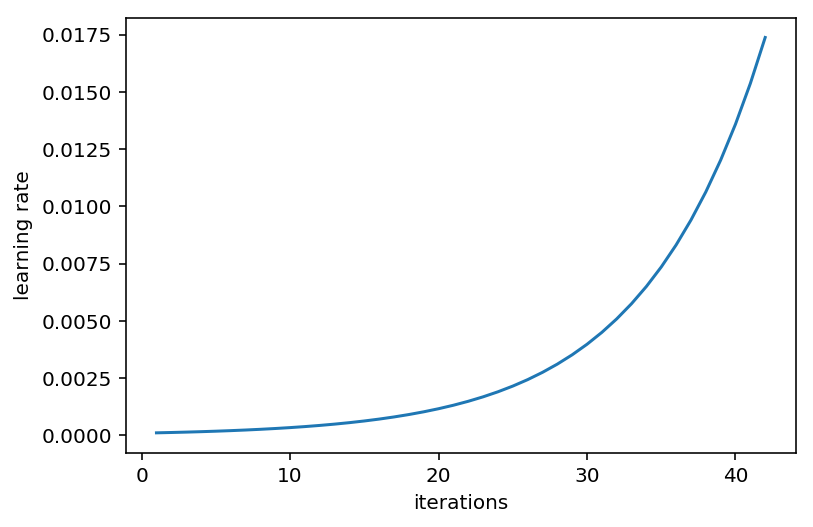

In [6]:
# plot to show the learning rate is increasing for each iterations
lr_find.plot_lr()

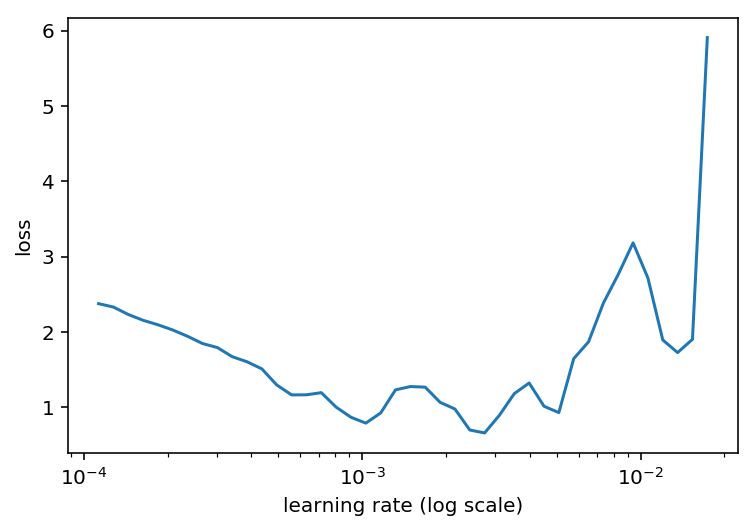

In [7]:
# plot the learning rate versus loss
lr_find.plot_loss()

Looking at the learning rate versus loss plot, we need to select a point on the graph above that's an order of magnitude before the minimum. The rationale for that is: the learning rate that corresponds to the minimum value is already a bit too high, since we are at the edge between improving and getting all over the place. We want to go one order of magnitude before, a value that's still improving our score but still on the safe side from an explosion.

In this example, the loss function starts diverging around 0.01, hence we can go back one order of magnitude and set it to 0.001.

In [8]:
K.set_value(model.optimizer.lr, 0.001)

# setup all the things for model fitting and start the training
model_name = 'weights'
address = model_name + '.hdf5'
print('model checkpoint address: ', address)
stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                     patience = 5, verbose = 1, mode = 'auto')
save = ModelCheckpoint(address, monitor = 'val_loss', 
                       verbose = 0, save_best_only = True)
callbacks = [stop, save]

model.save_weights('tmp.h5')
history1 = model.fit(X_train, Y_train, batch_size = batch_size, 
                     epochs = n_epochs, verbose = 1,
                     validation_split = validation_split,
                     callbacks = callbacks)

model checkpoint address:  weights.hdf5
Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.5481 - acc: 0.8369 - val_loss: 0.2081 - val_acc: 0.9367
Epoch 2/40
48000/48000 [==============================] - 2s 39us/step - loss: 0.1869 - acc: 0.9428 - val_loss: 0.2030 - val_acc: 0.9391
Epoch 3/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.1195 - acc: 0.9626 - val_loss: 0.0983 - val_acc: 0.9715
Epoch 4/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.0858 - acc: 0.9732 - val_loss: 0.0916 - val_acc: 0.9720
Epoch 5/40
48000/48000 [==============================] - 2s 39us/step - loss: 0.0660 - acc: 0.9789 - val_loss: 0.0830 - val_acc: 0.9762
Epoch 6/40
48000/48000 [==============================] - 2s 40us/step - loss: 0.0526 - acc: 0.9836 - val_loss: 0.0851 - val_acc: 0.9747
Epoch 7/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.0422 - 

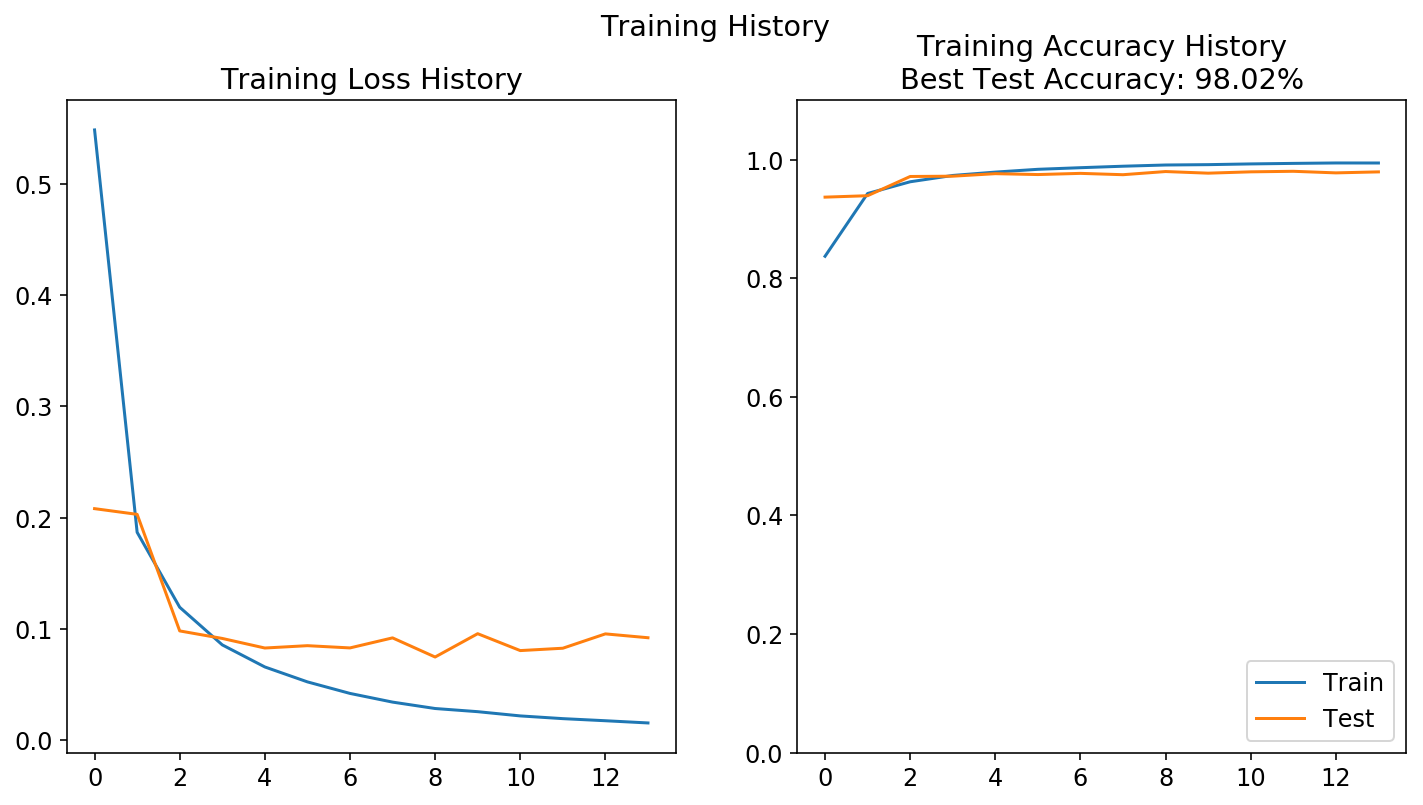

In [9]:
plt.rcParams['font.size'] = 12


def vis_keras_history(history, figsize = (12, 6), fig_path = None):
    """Plot keras' loss and accuracy history"""
    fig, ax = plt.subplots(1, 2, figsize = figsize)
    fig.suptitle('Training History')

    ax[0].plot(history['loss'], label = 'Train')
    ax[0].plot(history['val_loss'], label = 'Test')
    ax[0].set_title('Training Loss History')

    best_acc = np.max(history['val_acc']) * 100
    ax[1].plot(history['acc'], label = 'Train')
    ax[1].plot(history['val_acc'], label = 'Test')    
    ax[1].set_ylim([0, 1.1]) 
    ax[1].set_title('Training Accuracy History\nBest Test Accuracy: {:0.2f}%'.format(best_acc))     
    ax[1].legend(loc = 'lower right', fontsize = 12)

    if fig_path is not None:
        plt.savefig(fig_path)

    plt.show()
    
    
vis_keras_history(history1.history)

In [10]:
# .evaluate gives the loss and metric evaluation score for the dataset
score1 = model.evaluate(X_test, Y_test, verbose = 0)
score1

[0.08068248672079571, 0.9812]

In [11]:
K.set_value(model.optimizer.lr, 0.01)
model.load_weights('tmp.h5')
history2 = model.fit(X_train, Y_train, batch_size = batch_size, 
                     epochs = n_epochs, verbose = 1,
                     validation_split = validation_split,
                     callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 2s 40us/step - loss: 14.1973 - acc: 0.1067 - val_loss: 14.3760 - val_acc: 0.1081
Epoch 2/40
48000/48000 [==============================] - 2s 40us/step - loss: 14.4499 - acc: 0.1035 - val_loss: 14.3760 - val_acc: 0.1081
Epoch 3/40
48000/48000 [==============================] - 2s 39us/step - loss: 14.4499 - acc: 0.1035 - val_loss: 14.3760 - val_acc: 0.1081
Epoch 4/40
48000/48000 [==============================] - 2s 41us/step - loss: 14.4499 - acc: 0.1035 - val_loss: 14.3760 - val_acc: 0.1081
Epoch 5/40
48000/48000 [==============================] - 2s 41us/step - loss: 14.4499 - acc: 0.1035 - val_loss: 14.3760 - val_acc: 0.1081
Epoch 6/40
48000/48000 [==============================] - 2s 39us/step - loss: 14.4499 - acc: 0.1035 - val_loss: 14.3760 - val_acc: 0.1081
Epoch 00006: early stopping


In [12]:
score2 = model.evaluate(X_test, Y_test, verbose = 0)
score2

[14.461155044555664, 0.1028]

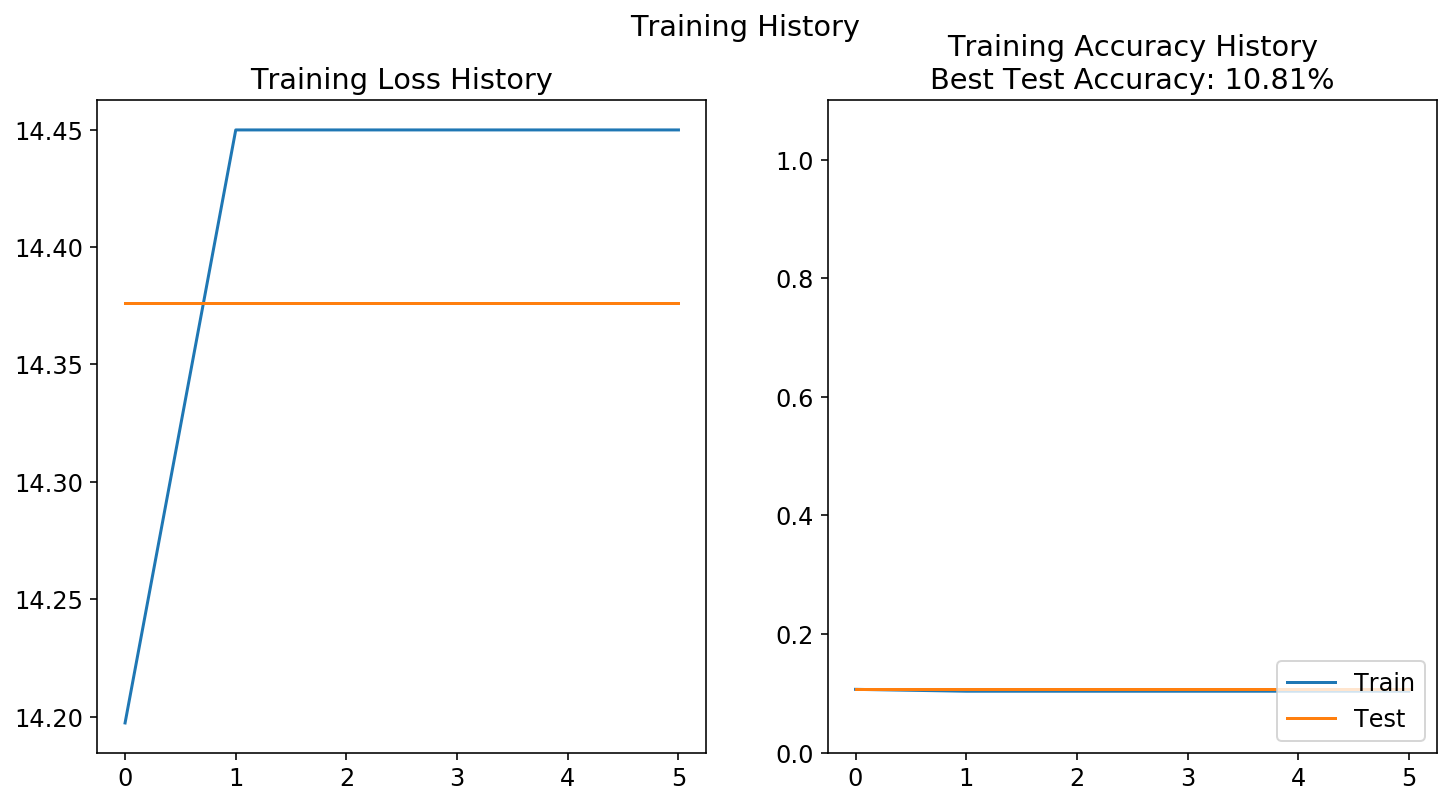

In [13]:
vis_keras_history(history2.history)

In [14]:
K.set_value(model.optimizer.lr, 0.0001)
model.load_weights('tmp.h5')
history3 = model.fit(X_train, Y_train, batch_size = batch_size, 
                     epochs = n_epochs, verbose = 1,
                     validation_split = validation_split,
                     callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 2s 41us/step - loss: 1.1150 - acc: 0.7286 - val_loss: 0.4329 - val_acc: 0.8896
Epoch 2/40
48000/48000 [==============================] - 2s 40us/step - loss: 0.4208 - acc: 0.8816 - val_loss: 0.2885 - val_acc: 0.9194
Epoch 3/40
48000/48000 [==============================] - 2s 39us/step - loss: 0.3212 - acc: 0.9079 - val_loss: 0.2389 - val_acc: 0.9333
Epoch 4/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.2740 - acc: 0.9220 - val_loss: 0.2088 - val_acc: 0.9410
Epoch 5/40
48000/48000 [==============================] - 2s 40us/step - loss: 0.2378 - acc: 0.9329 - val_loss: 0.1847 - val_acc: 0.9496
Epoch 6/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.2104 - acc: 0.9392 - val_loss: 0.1681 - val_acc: 0.9523
Epoch 7/40
48000/48000 [==============================] - 2s 39us/step - loss: 0.1879 - acc: 0.9456 - val_loss: 0.1586 - val_acc

In [15]:
score3 = model.evaluate(X_test, Y_test, verbose = 0)
score3

[0.06335252811950631, 0.9807]

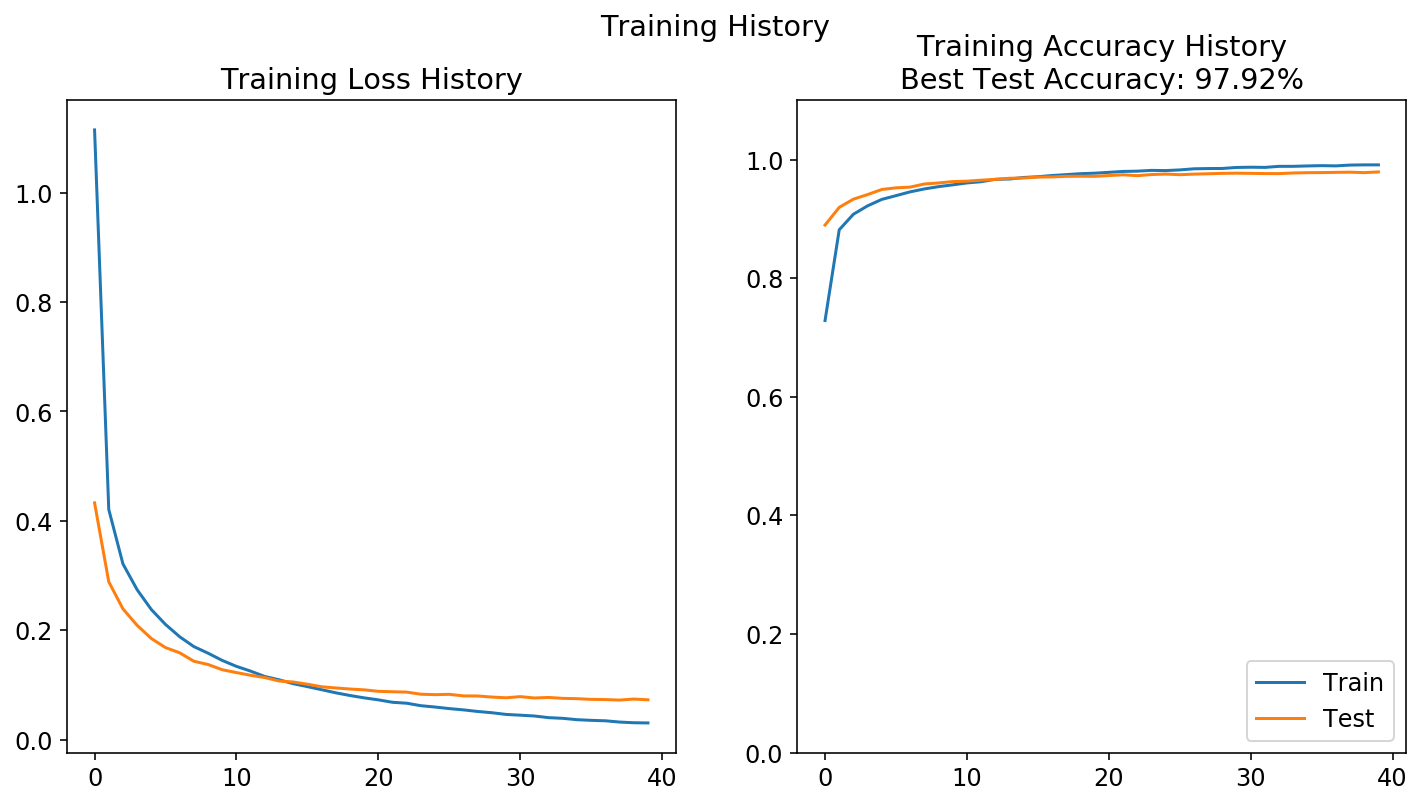

In [16]:
vis_keras_history(history3.history)

## Cyclical Learning Rate (CLR)

Selecting a good starting value for the learning rate is just one part of the problem. Another thing to look out for is the learning schedule, i.e. how to change the learning rate during training. The conventional wisdom is that the learning rate should decrease over time to prevent overshooting the minimum. However, it has been shown it might be useful to periodically vary the learning rate between a lower and upper bound. Although, increasing the learning rate might have a short term negative effect and yet it can be beneficial for the long-run. The reasoning is that the periodic higher learning rates within the training helps the model jump out of any local minima or saddle points if it ever enters into one.

[Paper: L. Smith - Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186) introduces different functional forms to perform this type of results, for example the screenshot below is the triangle policy, where the learning rates are restarted after every few iterations.

<img src="img/triangle.png" width="60%" height="60%">

In the plot above, the blue line represents the learning rate will oscillate between these the red bounds and an input parameter step size will control the number of iterations that the learning rate will traverse between the bounds.

To define/clarify some terminology: Consider a training dataset with 50,000 instances.

- Epoch: An epoch is one run of our training algorithm across the entire dataset.
- Iteration: If we set a batch size of 100, we get 500 batches in 1 epoch or 500 iterations. The iteration count is accumulated over epochs, so that in epoch 2, we get iterations 501 to 1000 for the same batch of 500, and so on.
- Cycle: As many iterations where we want our learning rate to go from a minimum learning rate (our lower bound) to our maximum learning rate (upper bound).
- Stepsize: Half of a cycle.

The code chunk below shows the implementation for the triangle2 policy, where the learning rate is cut in half at the end of each cycle.

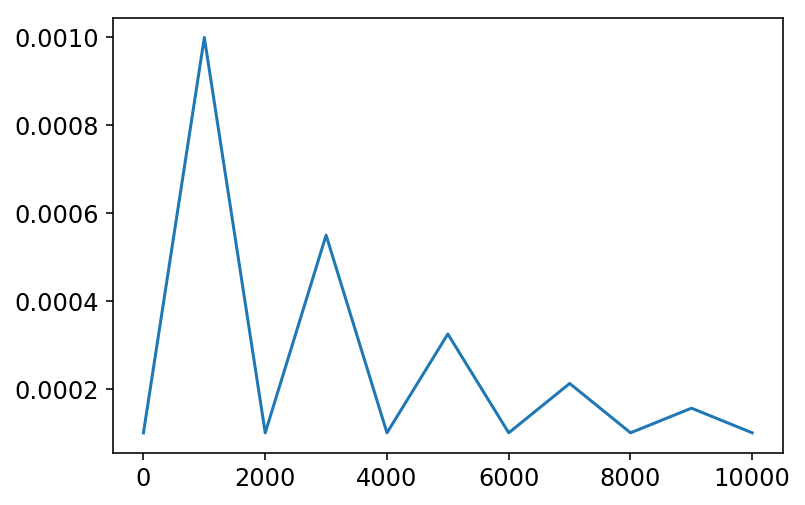

In [17]:
# Demo of how the learning rate varies with iterations

def get_triangular2_lr(iteration, step_size, min_lr, max_lr):
    """triangular 2 learning rate"""
    cycle = np.floor(1 + iteration / (2 * step_size))
    x = np.abs(iteration / step_size - 2 * cycle + 1)
    triangle_scaling = np.maximum(0, (1 - x)) / (2 ** (cycle - 1))
    return min_lr + (max_lr - min_lr) * triangle_scaling


n_iterations = 10000
stepsize = 1000
min_lr = 0.0001
max_lr = 0.001
lr_trend = [get_triangular2_lr(iteration, stepsize, min_lr, max_lr)
            for iteration in range(n_iterations)]

plt.plot(lr_trend)
plt.show()

Let's give this cyclical learning rate a try to see if it improves the overall model performance. For the input parameter stepsize, the paper suggests, after experimentation, that the stepsize be set to 2-10 times the number of iterations in an epoch. In the previous example, since we had 500 iterations per epoch, setting stepsize from 1000 to 5000 would do.

In [18]:
from keras_utils import LRCycle


# step size = 2 ~ 10 times the number of iterations in an epoch
clr_triangular = LRCycle(min_lr = 0.0001, max_lr = 0.001, step_size = iterations * 2)
callbacks = [stop, save, clr_triangular]

model.load_weights('tmp.h5')
history4 = model.fit(X_train, Y_train, batch_size = batch_size, 
                     epochs = n_epochs, verbose = 1,
                     validation_split = validation_split,
                     callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 2s 40us/step - loss: 0.8716 - acc: 0.7656 - val_loss: 0.2873 - val_acc: 0.9147
Epoch 2/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.2703 - acc: 0.9185 - val_loss: 0.1999 - val_acc: 0.9396
Epoch 3/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.1549 - acc: 0.9528 - val_loss: 0.1094 - val_acc: 0.9676
Epoch 4/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.0975 - acc: 0.9701 - val_loss: 0.0918 - val_acc: 0.9707
Epoch 5/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.0800 - acc: 0.9763 - val_loss: 0.0929 - val_acc: 0.9708
Epoch 6/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.0772 - acc: 0.9766 - val_loss: 0.0919 - val_acc: 0.9718
Epoch 7/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.0636 - acc: 0.9808 - val_loss: 0.0821 - val_acc

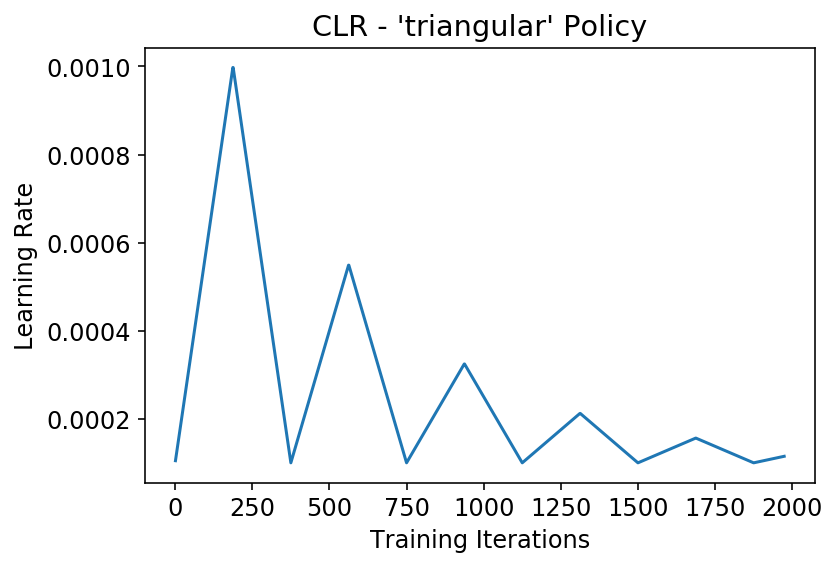

In [19]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])
plt.show()

In [20]:
score4 = model.evaluate(X_test, Y_test, verbose = 0)
score4

[0.05892328269994759, 0.9829]

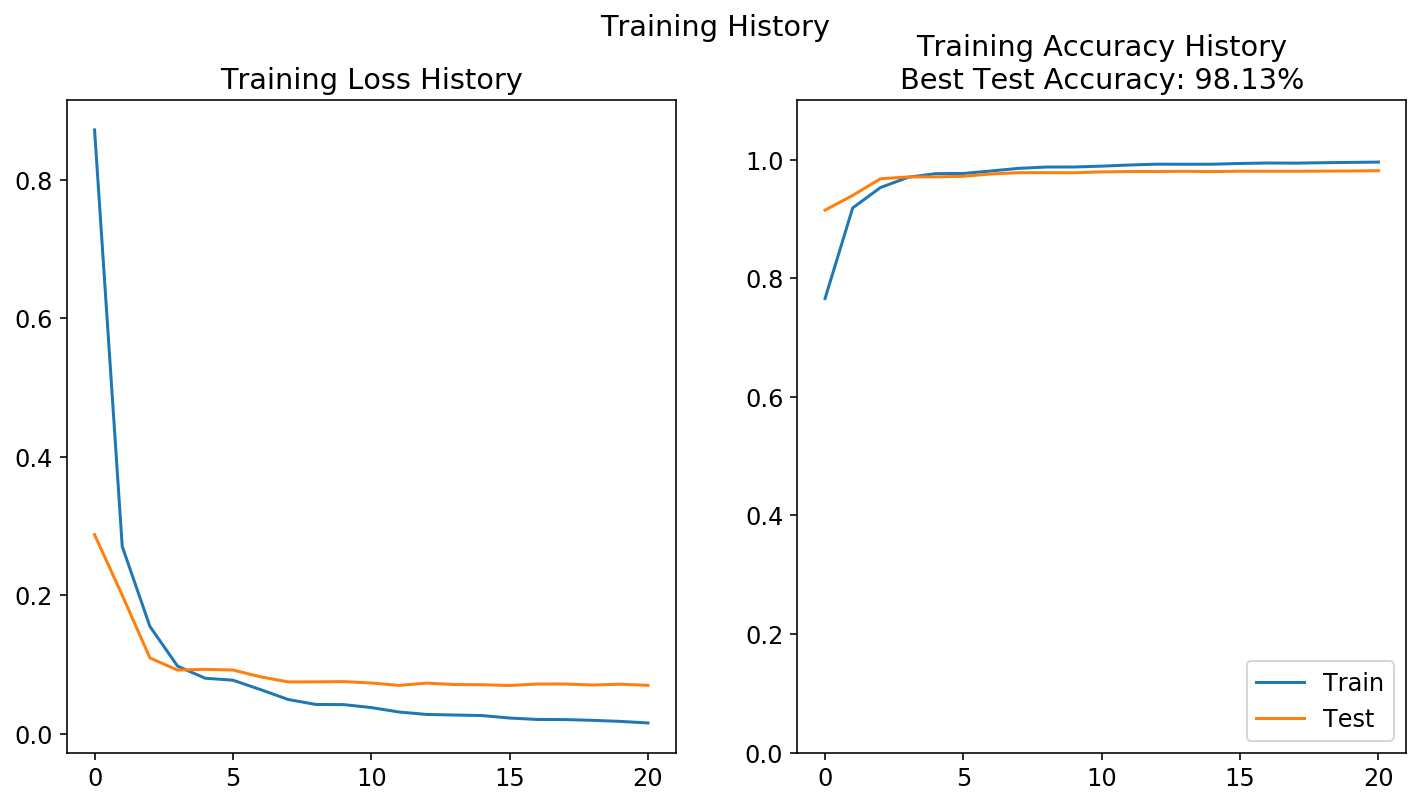

In [21]:
vis_keras_history(history4.history)

The table below curates all the experiments we ran above so we can compare the performance, the epoch it took to reach that performance for different learning rate decisions. Results will definitely vary across different runs and different datasets. But hopefully, on this dataset, we can see that using learning rate finder to set a reasonable learning rate and leveraging cyclical learning rates are both useful techniques to keep in our toolbox.

In [22]:
comparisons = []
scores = [score1, score2, score3, score4]
histories = [history1, history2, history3, history4]
for score, history in zip(scores, histories):
    epoch = [len(history.history['loss'])]
    comparisons.append(epoch + score)

df = pd.DataFrame(comparisons, columns = ['epoch', 'loss', 'accuracy'])
df.index = ['lr=0.001', 'lr=0.01', 'lr=0.0001', 'clr=0.0001-0.001']
df

,epoch,loss,accuracy
lr=0.001,14,0.080682,0.9812
lr=0.01,6,14.461155,0.1028
lr=0.0001,40,0.063353,0.9807
clr=0.0001-0.001,21,0.058923,0.9829


## Conclusion

- The learning rate finder can be valuable whenever we are facing a new architecture or dataset.
- After using the learning rate finder to estimate a reasonable learning rate, we can use it to estimate the boundary for the cyclical learning rate policies. One reasonable range it to set the lower bound to the learning rate when the loss starts to decrease and set the upper bound to the learning rate when the loss starts to become ragged/unstable. This policy is easier to implement compared with adaptive learning methods and incurs essentially no additional computational expense. And note that it can also be used in conjunction with adaptive learning rate methods.
- The original paper contains other empirical results showing the effectiveness of these methods in case you're curious.

# Reference

- [Github: Cyclical Learning Rate (CLR)](https://github.com/bckenstler/CLR)
- [Blog: The Cyclical Learning Rate technique](http://teleported.in/posts/cyclic-learning-rate/)
- [Blog: Improving the way we work with learning rate](https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b)
- [Blog: Estimating an Optimal Learning Rate For a Deep Neural Network](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0)
- [Paper: L. Smith - Cyclical Learning Rates for Training Neural Networks (2017)](https://arxiv.org/abs/1506.01186)